# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
fto = '/storage/experiments/2021/03_REFLECT3/AirdosCvetsiNaITl_9c/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/0609_bourka_sobeslav/GEODOS/BF/DATALOG.TXT' #  File to Open
#fto = '/storage/experiments/2021/0605_bourka_radosovice/GEODOS/BF/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/0803_bourka_votice/geodos/DATALOG.TXT'
fto = '/storage/stations/Polednik/geodos/2021/10/10/DATALOG.TXT'
#fto = '/storage/stations/Polednik/geodos/2021/10/13/DATALOG.TXT'
#fto = '/storage/stations/Polednik/geodos/2021/10/EC/DATALOG.TXT'


l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a20091e412a000a0000010
f.v.:  51832f3
0         GEO2
68310     GEO2
68311     GEO2
68312     GEO2
68313     GEO2
          ... 
209368    GEO2
209369    GEO2
209370    GEO2
209371    GEO2
209372    GEO2
Name: 1, Length: 141064, dtype: object
207379
209372


## Fill position and time

In [63]:
#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC
14,$HIST,0,46.12,96171.00,28.31,3.81,-52,556,891,0,...,NaN,NaN,NaN,NaN,NaN,456.4,49.260736,14.691802,0,2021-08-03 16:03:50.020
15,$HITS,4,85687,44,164719,9,166285,78,232381,19,...,NaN,NaN,NaN,NaN,NaN,456.4,49.260736,14.691802,0,2021-08-03 16:03:50.020
16,$HIST,1,61.93,96236.50,28.31,3.81,-29,556,891,2,...,NaN,NaN,NaN,NaN,NaN,456.4,49.260736,14.691802,1,2021-08-03 16:04:05.830
17,$HITS,3,51052,9,89843,14,197296,11,891,2,...,NaN,NaN,NaN,NaN,NaN,456.4,49.260736,14.691802,1,2021-08-03 16:04:05.830
18,$HIST,2,77.97,96261.25,28.31,3.81,-21,556,891,0,...,NaN,NaN,NaN,NaN,NaN,456.4,49.260736,14.691802,2,2021-08-03 16:04:21.870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,$HITS,4,61998,57,163797,34,180580,10,226938,10,...,NaN,NaN,NaN,NaN,NaN,438.2,49.260266,14.694010,292,2021-08-03 17:34:39.540
1354,$HIST,293,5511.41,96141.00,22.75,3.78,-18,498,891,2,...,NaN,NaN,NaN,NaN,NaN,438.2,49.260266,14.694010,293,2021-08-03 17:34:55.280
1355,$HITS,3,70594,10,171945,22,193889,45,891,2,...,NaN,NaN,NaN,NaN,NaN,438.2,49.260266,14.694010,293,2021-08-03 17:34:55.280
1356,$HIST,294,5527.15,96143.25,22.75,3.78,-17,497,891,1,...,NaN,NaN,NaN,NaN,NaN,438.2,49.260266,14.694010,294,2021-08-03 17:35:11.020


## Galileo support

In [3]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,499,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
1,$GNVTG,GEO2,T,1290c00806a20091e412a000a0000010,M,0.377,N,0.697,K,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
2,$GNGGA,143208.00,4903.84979,N,01323.70453,E,1,09,1.01,1351.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
3,$GNGSA,A,3,03,04,22,01,17,19,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
4,$GNGSA,A,3,03,04,22,01,17,19,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
9,$GLGSV,2,1,06,68,26,053,17,70,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,$HITS,4,101776,56,118812,9,210650,10,229111,16,...,NaN,False,501129240.0,502052810.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30807,2021-08-18 09:59:40.570
68306,$HIST,30808,502068.73,86634.75,6.50,-0.26,-257,-257,-257,55524,...,NaN,False,501129240.0,502068730.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30808,2021-08-18 09:59:56.490
68307,$HITS,3,209350,10,258456,27,261942,13,-257,55524,...,NaN,False,501129240.0,502068730.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30808,2021-08-18 09:59:56.490
68308,$HIST,30809,502084.67,86647.50,6.50,-0.26,-257,-257,-257,54655,...,NaN,False,501129240.0,502084670.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30809,2021-08-18 10:00:12.430


In [36]:
df.loc[(df[0]=='$TIME') & (df['flag'])]

,0,1,2,3,4,5,6,7,8,9,...,499,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC


## Add individual events to histogram

In [4]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:270].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)
hits = df.loc[df[0]=='$HITS'].copy()
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits.set_index('meas', inplace=True)


In [55]:
for index, row in hits.iterrows():
    for j in range(2,2+row[1]*2,2):
        hist.loc[index,int(row[j+1])+3] += 1


In [49]:
yy = hist.loc['2021-08-15 18:08:00':'2021-08-15 18:11:00']
yy.iloc[:,11:]

,11,12,13,14,15,16,17,18,19,20,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-08-15 18:08:15.950,0.0,2,2.0,1.0,0.0,0.0,0.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:08:15.950,5.0,12.033333
2021-08-15 18:08:31.900,8.0,6,1.0,2.0,1.0,0.0,2.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:08:31.900,20.0,12.400000
2021-08-15 18:08:47.770,4.0,4,5.0,4.0,1.0,2.0,1.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:08:47.770,21.0,12.766667
2021-08-15 18:09:03.770,3.0,2,1.0,0.0,1.0,1.0,0.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:09:03.770,8.0,12.633333
2021-08-15 18:09:19.620,22.0,33,29.0,23.0,21.0,7.0,3.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:09:19.620,138.0,17.033333
2021-08-15 18:09:35.570,23.0,21,18.0,11.0,1.0,2.0,1.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:09:35.570,77.0,19.366667
2021-08-15 18:09:51.500,10.0,8,3.0,2.0,4.0,2.0,0.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:09:51.500,29.0,19.933333
2021-08-15 18:10:07.420,3.0,6,3.0,7.0,0.0,1.0,1.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:10:07.420,21.0,20.200000
2021-08-15 18:10:23.370,2.0,5,1.0,0.0,1.0,1.0,1.0,0,0,0,...,0,0,0,NaN,NaN,49.064126,13.395212,2021-08-15 18:10:23.370,11.0,20.166667


In [39]:
df.iloc[:,10:]

,10,11,12,13,14,15,16,17,18,19,...,499,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
14,42326,2.0,2,1.0,1.0,0.0,1.0,1.0,66.0,25.0,...,NaN,False,10730.0,26810.0,NaN,49.064136,13.395068,2021-08-12 14:32:09,0,2021-08-12 14:32:25.080
15,42326,2.0,2,1.0,1.0,0.0,1.0,1.0,66.0,25.0,...,NaN,False,10730.0,26810.0,NaN,49.064136,13.395068,2021-08-12 14:32:09,0,2021-08-12 14:32:25.080
16,45578,5.0,2,0.0,0.0,2.0,2.0,1.0,66.0,25.0,...,NaN,False,10730.0,42970.0,NaN,49.064136,13.395068,2021-08-12 14:32:09,1,2021-08-12 14:32:41.240
17,45578,5.0,2,0.0,0.0,2.0,2.0,1.0,66.0,25.0,...,NaN,False,10730.0,42970.0,NaN,49.064136,13.395068,2021-08-12 14:32:09,1,2021-08-12 14:32:41.240
18,49302,3.0,2,1.0,0.0,0.0,0.0,1.0,66.0,25.0,...,NaN,False,10730.0,59130.0,NaN,49.064136,13.395068,2021-08-12 14:32:09,2,2021-08-12 14:32:57.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,8698,4.0,1,1.0,1.0,1.0,1.0,0.0,174594.0,81.0,...,NaN,False,501129240.0,502052810.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30807,2021-08-18 09:59:40.570
68306,9996,5.0,1,2.0,1.0,0.0,0.0,0.0,174594.0,81.0,...,NaN,False,501129240.0,502068730.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30808,2021-08-18 09:59:56.490
68307,9996,5.0,1,2.0,1.0,0.0,0.0,0.0,174594.0,81.0,...,NaN,False,501129240.0,502068730.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30808,2021-08-18 09:59:56.490
68308,10863,7.0,4,1.0,0.0,1.0,0.0,0.0,174594.0,81.0,...,NaN,False,501129240.0,502084670.0,NaN,49.064121,13.395117,2021-08-18 09:44:17,30809,2021-08-18 10:00:12.430


## Plot Flux

/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


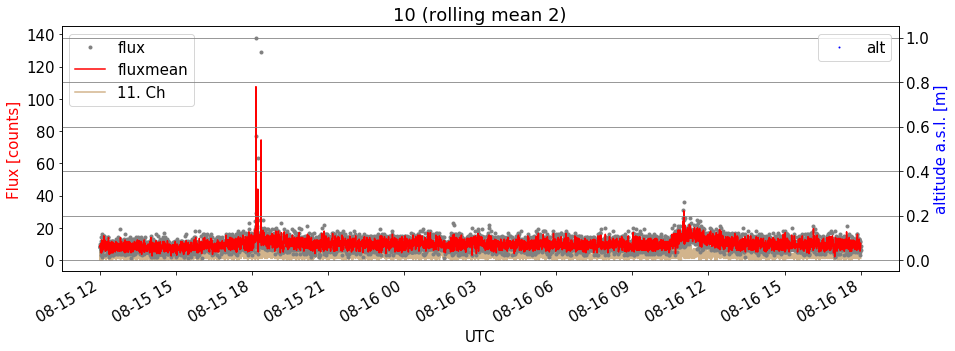

In [11]:
NOISE_LEVEL = 11
LAST_CHANNEL = 270
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', linestyle='none', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



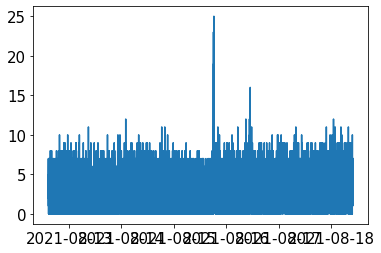

In [39]:
#plt.plot(xx['meas'],xx['flux'])
xx.sort_index(inplace=True)
plt.plot(xx['flux'])


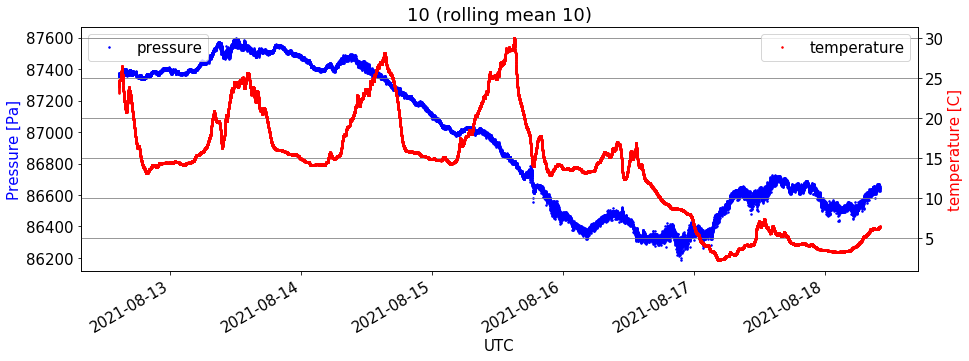

In [40]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



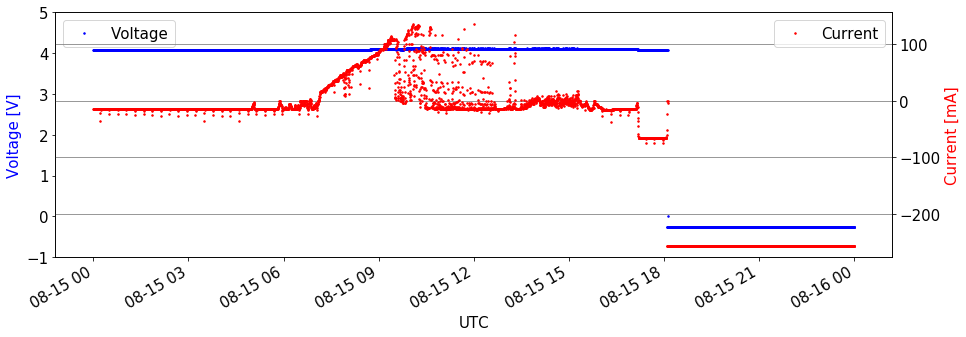

In [57]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']



xx[5].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[6].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



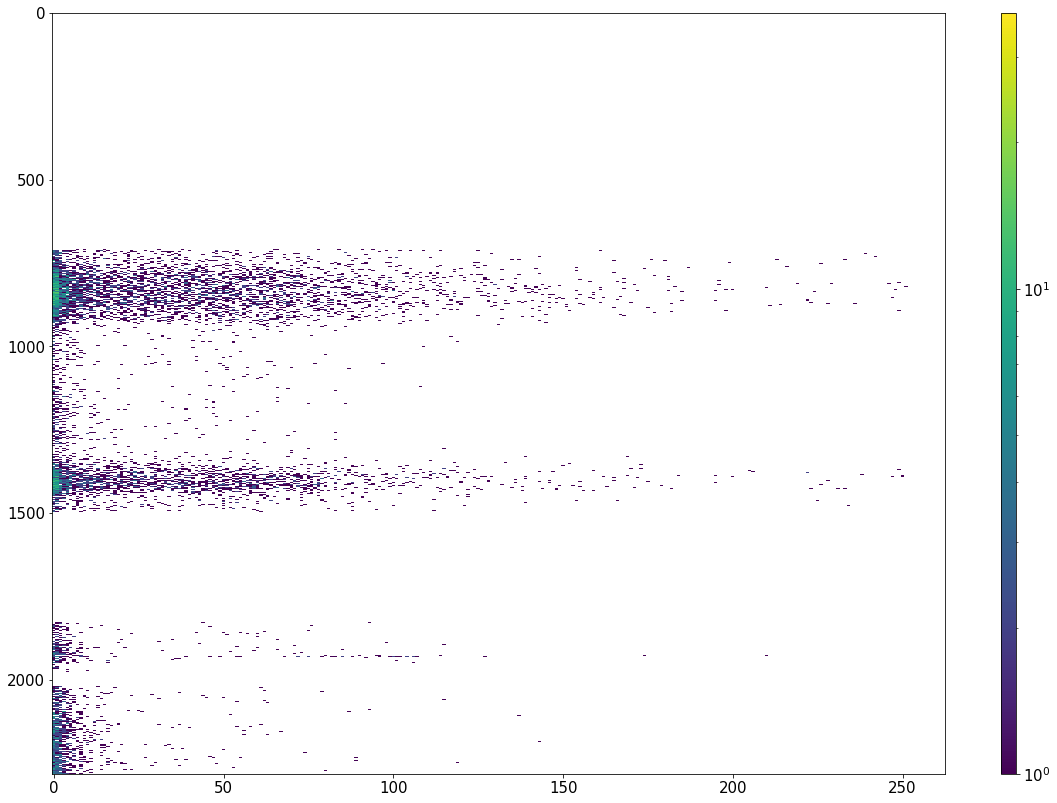

In [18]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((hist.iloc[:,7:270]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

In [16]:

hist['2021-03-24 13:00:00':'2021-03-24 13:01:00'].iloc[:,7:]


,7,8,9,10,11,12,13,14,15,16,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-03-24 13:00:19.550,10,6,2,4,3.0,2,1,1,1,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:19.550,91.0,97.0
2021-03-24 13:00:29.050,6,8,5,3,5.0,1,1,0,3,3,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:29.050,110.0,98.0
2021-03-24 13:00:38.800,6,7,3,3,3.0,3,4,0,2,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:38.800,90.0,98.1
2021-03-24 13:00:48.140,10,7,9,8,3.0,2,3,0,3,2,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:48.140,101.0,98.0
2021-03-24 13:00:57.710,10,8,2,5,4.0,1,2,2,1,1,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:57.710,106.0,99.5


In [15]:
hist

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-08-12 14:32:25.080,$HIST,0,26.81,87376.50,23.13,4.16,-22,898,898,23198,...,0,0,0,NaN,NaN,49.064136,13.395068,2021-08-12 14:32:25.080,2.0,NaN
2021-08-12 14:32:41.240,$HIST,1,42.97,87360.25,23.25,4.16,-17,898,898,19938,...,0,0,0,NaN,NaN,49.064136,13.395068,2021-08-12 14:32:41.240,5.0,NaN
2021-08-12 14:32:57.400,$HIST,2,59.13,87357.00,23.38,4.16,-15,898,898,16221,...,0,0,0,NaN,NaN,49.064136,13.395068,2021-08-12 14:32:57.400,3.0,NaN
2021-08-12 14:33:13.570,$HIST,3,75.30,87357.25,23.56,4.16,-15,898,898,17452,...,0,0,0,NaN,NaN,49.064136,13.395068,2021-08-12 14:33:13.570,1.0,NaN
2021-08-12 14:33:29.430,$HIST,4,91.16,87356.50,23.63,4.16,-14,898,898,20549,...,0,0,0,NaN,NaN,49.064136,13.395068,2021-08-12 14:33:29.430,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-18 09:59:08.720,$HIST,30805,502020.96,86654.00,6.44,-0.26,-257,-257,-257,57339,...,0,0,0,NaN,NaN,49.064121,13.395117,2021-08-18 09:59:08.720,2.0,3.7
2021-08-18 09:59:24.640,$HIST,30806,502036.88,86639.50,6.44,-0.26,-257,-257,-257,56530,...,0,0,0,NaN,NaN,49.064121,13.395117,2021-08-18 09:59:24.640,4.0,3.7
2021-08-18 09:59:40.570,$HIST,30807,502052.81,86625.75,6.44,-0.26,-257,-257,-257,56821,...,0,0,0,NaN,NaN,49.064121,13.395117,2021-08-18 09:59:40.570,4.0,3.9
